# IMPORTS

In [1]:
import requests
import pandas as pd

# ACTIVITY 1

## 1.1 Sub-activity : Open Data COVID 19 API

### TASK 1

In [2]:
from typing import Iterable, Dict, Union, List
from json import dumps
from requests import get
from http import HTTPStatus


StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]

# This function is created to send the API requests to retrieve information and returns the information matched to that API as 
# a list of dictionaries
def get_API_data(filters: FiltersType, structure: StructureType,
                          as_csv: bool = False) -> APIResponseType:
    """
    Extracts paginated data by requesting all of the pages
    and combining the results.

    Parameters
    ----------
    filters: Iterable[str]
        API filters. See the API documentations for additional
        information.

    structure: Dict[str, Union[dict, str]]
        Structure parameter. See the API documentations for
        additional information.

    as_csv: bool
        Return the data as CSV. [default: ``False``]

    Returns
    -------
    Union[List[StructureType], str]
        Comprehensive list of dictionaries containing all the data for
        the given ``filters`` and ``structure``.
    """
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    
    key, value = next(iter(filters.items()))

    api_params = {
        "filters": key+'='+value,
        "structure": dumps(structure, separators=(",", ":")),
        "format": "json" if not as_csv else "csv"
    }

    data = list()

    page_number = 1

    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = get(endpoint, params=api_params, timeout=10)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        if as_csv:
            csv_content = response.content.decode()

            # Removing CSV header (column names) where page 
            # number is greater than 1.
            if page_number > 1:
                data_lines = csv_content.split("\n")[1:]
                csv_content = str.join("\n", data_lines)

            data.append(csv_content.strip())
            page_number += 1
            continue

        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    if not as_csv:
        return data

    # Concatenating CSV pages
    return str.join("\n", data)

### TASK 2

In [3]:
# setting the query filters as dictionary
query_filters = {
        "areaType":"region"
    }

query_filters1 = {
        "areaType":"nation"
    }

# initializing the dictionary for query structures to retrieve information by initialising the values to API names
query_structure = {
        "date": "date",
        "name": "areaName",
        "daily_cases": "newCasesBySpecimenDate",
        "cumulative_cases": "cumCasesBySpecimenDate",
        "daily_deaths": "newDeaths28DaysByPublishDate",
        "cumulative_deaths": "cumDeaths28DaysByPublishDate",
        "cumulative_vaccinated":"cumPeopleVaccinatedSecondDoseByVaccinationDate",
        "vaccination_age":"vaccinationsAgeDemographics"
        
    }

# Calling the function get_API_data twice to create two lists of dictionaries
results_json_regional = get_API_data(query_filters, query_structure)
results_json_national = get_API_data(query_filters1, query_structure)

## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### TASK 3

In [4]:
# Combining the two list of dictionaries into a single list of dictionaries
overall_results = results_json_national+results_json_regional # concatenating the two lists

### TASK 4

In [5]:
# converting the combined list of dictionaries into a dataframe 
covid_data = pd.DataFrame(overall_results, columns= ['date', 'name', 'daily_cases', 'cumulative_cases',
'daily_deaths', 'cumulative_deaths', 'cumulative_vaccinated', 'vaccination_age'])

In [6]:
covid_data

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
0,2022-12-14,England,3393.0,20350226.0,NaN,NaN,41983471.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
1,2022-12-13,England,5510.0,20346833.0,NaN,NaN,41982966.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
2,2022-12-12,England,5669.0,20341323.0,NaN,NaN,41982478.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
3,2022-12-11,England,3932.0,20335654.0,NaN,NaN,41982091.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
4,2022-12-10,England,3071.0,20331722.0,NaN,NaN,41981702.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
...,...,...,...,...,...,...,...,...
13275,2020-02-16,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13276,2020-02-15,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13277,2020-02-14,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13278,2020-02-13,West Midlands,0.0,1.0,NaN,NaN,NaN,[]


### TASK 5

In [7]:
# removing all the rows that has information about the region 'England' 
covid_data = covid_data.drop(covid_data[covid_data['name']=='England'].index)

In [8]:
covid_data

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
1050,2022-05-20,Northern Ireland,NaN,NaN,0.0,3445.0,NaN,[]
1051,2022-05-19,Northern Ireland,190.0,713294.0,4.0,3445.0,NaN,[]
1052,2022-05-18,Northern Ireland,266.0,713104.0,1.0,3441.0,NaN,[]
1053,2022-05-17,Northern Ireland,318.0,712838.0,2.0,3440.0,NaN,[]
1054,2022-05-16,Northern Ireland,356.0,712520.0,1.0,3438.0,NaN,[]
...,...,...,...,...,...,...,...,...
13275,2020-02-16,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13276,2020-02-15,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13277,2020-02-14,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13278,2020-02-13,West Midlands,0.0,1.0,NaN,NaN,NaN,[]


### TASK 6

In [9]:
# renaming the column 'name' to 'area'
covid_data= covid_data.rename(columns={'name':'area'})

In [10]:
covid_data

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
1050,2022-05-20,Northern Ireland,NaN,NaN,0.0,3445.0,NaN,[]
1051,2022-05-19,Northern Ireland,190.0,713294.0,4.0,3445.0,NaN,[]
1052,2022-05-18,Northern Ireland,266.0,713104.0,1.0,3441.0,NaN,[]
1053,2022-05-17,Northern Ireland,318.0,712838.0,2.0,3440.0,NaN,[]
1054,2022-05-16,Northern Ireland,356.0,712520.0,1.0,3438.0,NaN,[]
...,...,...,...,...,...,...,...,...
13275,2020-02-16,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13276,2020-02-15,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13277,2020-02-14,West Midlands,0.0,1.0,NaN,NaN,NaN,[]
13278,2020-02-13,West Midlands,0.0,1.0,NaN,NaN,NaN,[]


### TASK 7

In [11]:
# changin the data type of the column date to datetime
covid_data['date']=pd.to_datetime(covid_data['date'])

In [12]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12230 entries, 1050 to 13279
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   12230 non-null  datetime64[ns]
 1   area                   12230 non-null  object        
 2   daily_cases            12219 non-null  float64       
 3   cumulative_cases       12217 non-null  float64       
 4   daily_deaths           10242 non-null  float64       
 5   cumulative_deaths      10254 non-null  float64       
 6   cumulative_vaccinated  7368 non-null   float64       
 7   vaccination_age        12230 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 859.9+ KB


### TASK 8

In [13]:
covid_data.isnull().sum()

# isnull method returns the True or False value based on whether that particular row is null or not respectively.
# and I used sum method since it gives me the total sum of True values for every row which inturn will give the total 
# null values of every particular column

date                        0
area                        0
daily_cases                11
cumulative_cases           13
daily_deaths             1988
cumulative_deaths        1976
cumulative_vaccinated    4862
vaccination_age             0
dtype: int64

### TASK 9

In [14]:
# sorting the values by date since we need to fill missing values with most recent date
covid_data.sort_values(by='date',inplace=True)

In [15]:
covid_data

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
6003,2020-01-30,Yorkshire and The Humber,1.0,1.0,NaN,NaN,NaN,[]
6002,2020-01-31,Yorkshire and The Humber,0.0,1.0,NaN,NaN,NaN,[]
6001,2020-02-01,Yorkshire and The Humber,0.0,1.0,NaN,NaN,NaN,[]
6000,2020-02-02,Yorkshire and The Humber,0.0,1.0,NaN,NaN,NaN,[]
4952,2020-02-02,North West,1.0,1.0,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...
7751,2022-12-15,North East,NaN,NaN,21.0,9692.0,NaN,[]
6004,2022-12-15,East Midlands,NaN,NaN,53.0,16088.0,NaN,[]
3905,2022-12-15,North West,NaN,NaN,67.0,27619.0,NaN,[]
12242,2022-12-15,West Midlands,NaN,NaN,54.0,20599.0,NaN,[]


In [16]:
# grouping by area because we need to fill missing values only for each particular area 
covid_data['cumulative_cases'] = covid_data.groupby('area')['cumulative_cases'].ffill() 
# ffill fills the missing values with the previous row 

In [17]:
# grouping by area because we need to fill missing values only for each particular area
covid_data['cumulative_deaths'] = covid_data.groupby('area')['cumulative_deaths'].ffill()
# ffill fills the missing values with the previous row 

In [18]:
# grouping by area because we need to fill missing values only for each particular area
covid_data['cumulative_vaccinated'] = covid_data.groupby('area')['cumulative_vaccinated'].ffill()
# ffill fills the missing values with the previous row

### TASK 10

In [19]:
# assinging the dataframe as a new dataframe with no missing values 
covid_data = covid_data[covid_data['cumulative_vaccinated'].notnull()] # notnull() gives the rows with no missing values

In [20]:
covid_data.isnull().sum()
# confirming that there are no missing values in cumulative metrics column

date                       0
area                       0
daily_cases               11
cumulative_cases           0
daily_deaths             200
cumulative_deaths          0
cumulative_vaccinated      0
vaccination_age            0
dtype: int64

### TASK 11

In [21]:
# sorting the values by area and date since we need to calculate the rolling average only for that particular areas
covid_data.sort_values(['area','date'],inplace=True)

C:\anaconda\data\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
# creating a new column in covid_data dataframe 
covid_data['daily_cases_roll_avg'] = covid_data['daily_cases'].rolling(7).mean()
# rolling() gives the rolling average for the number of rows that we mention , we have mentioned 7 

C:\anaconda\data\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
# we are sorting it again since we added a new column , the values might have changed so we sort it again
covid_data.sort_values(['area','date'],inplace=True)

C:\anaconda\data\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# rolling() gives the rolling average for the number of rows that we mention , we have mentioned 7 
covid_data['daily_deaths_roll_avg'] = covid_data['daily_deaths'].rolling(7).mean()

C:\anaconda\data\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### TASK 12

In [25]:
# dropping the columns daily_cases, daily_deaths
covid_data.drop(['daily_cases','daily_deaths'],axis=1,inplace=True) 

C:\anaconda\data\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### TASK 13

In [26]:
# creating a dataframe with the required three columns 
covid_data_vaccinations = covid_data[['date','area','vaccination_age']].copy()
# copying the three columns from covid_data dataframe tp covid_data_vaccinations dataframe

In [27]:
covid_data_vaccinations

,date,area,vaccination_age
8318,2020-12-08,East Midlands,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
8317,2020-12-09,East Midlands,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
8316,2020-12-10,East Midlands,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
8315,2020-12-11,East Midlands,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
8314,2020-12-12,East Midlands,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
...,...,...,...
4957,2022-12-11,Yorkshire and The Humber,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
4956,2022-12-12,Yorkshire and The Humber,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
4955,2022-12-13,Yorkshire and The Humber,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
4954,2022-12-14,Yorkshire and The Humber,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."


In [28]:
# Dropping the vaccination_Age column from covid_Data
covid_data.drop('vaccination_age',axis=1,inplace=True)

C:\anaconda\data\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### TASK 14

In [29]:
covid_no_na = covid_data_vaccinations[covid_data_vaccinations['vaccination_age'].map(lambda d: len(d)) > 0] 
# covid_no_na means covid data without empty lists
# used the map function to run the loop and skip the empty lists in vaccination_age

# CITATION -  https://stackoverflow.com/questions/71314379/df-explode-function-not-working-in-python
exploded_df = covid_no_na.set_index(['date','area'])['vaccination_age'].explode()
# explode() will convert the list of dictionaries inside the vaccination age column into seperate rows 

covid_data_vaccinations_wide = pd.DataFrame(exploded_df.tolist(), index=exploded_df.index).reset_index()
# when we create the dataframe , we use tolist() to make each and every key of the dictionary to become a column name 
covid_data_vaccinations_wide

,date,area,age,VaccineRegisterPopulationByVaccinationDate,cumPeopleVaccinatedAutumn22ByVaccinationDate,cumPeopleVaccinatedCompleteByVaccinationDate,cumPeopleVaccinatedSpring22ByVaccinationDate,newPeopleVaccinatedAutumn22ByVaccinationDate,newPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedSpring22ByVaccinationDate,...,cumPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,cumPeopleVaccinatedThirdInjectionByVaccinationDate,newPeopleVaccinatedThirdInjectionByVaccinationDate,cumVaccinationAutumn22UptakeByVaccinationDatePercentage,cumVaccinationSpring22UptakeByVaccinationDatePercentage,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage,cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage
0,2020-12-08,East Midlands,05_11,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,2020-12-08,East Midlands,12_15,249087.0,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,2020-12-08,East Midlands,16_17,0.0,NaN,0.0,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
3,2020-12-08,East Midlands,18_24,451190.0,NaN,9.0,NaN,NaN,0.0,NaN,...,9.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
4,2020-12-08,East Midlands,25_29,345037.0,NaN,35.0,NaN,NaN,0.0,NaN,...,35.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140761,2022-12-14,Yorkshire and The Humber,75+,520480.0,NaN,NaN,408527.0,NaN,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,78.490,NaN,NaN,NaN,NaN
140762,2022-12-14,Yorkshire and The Humber,75_79,235907.0,199773.0,228624.0,176135.0,107.0,0.0,0.0,...,228624.0,0.0,224433.0,1.0,84.683,74.663,97.3,96.9,96.9,95.1
140763,2022-12-14,Yorkshire and The Humber,80_84,145077.0,123267.0,140918.0,119476.0,59.0,0.0,0.0,...,140918.0,0.0,138424.0,1.0,84.967,82.354,97.5,97.1,97.1,95.4
140764,2022-12-14,Yorkshire and The Humber,85_89,90917.0,76662.0,88346.0,74353.0,50.0,1.0,0.0,...,88346.0,1.0,86679.0,0.0,84.321,81.781,97.5,97.2,97.2,95.3


In [30]:
# dropping the additional rows which are not mentioned in the question
covid_data_vaccinations_wide.drop(['cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage','cumPeopleVaccinatedAutumn22ByVaccinationDate','cumPeopleVaccinatedSpring22ByVaccinationDate','newPeopleVaccinatedAutumn22ByVaccinationDate','newPeopleVaccinatedSpring22ByVaccinationDate','newPeopleVaccinatedAutumn22ByVaccinationDate','cumVaccinationAutumn22UptakeByVaccinationDatePercentage','cumVaccinationSpring22UptakeByVaccinationDatePercentage'],axis=1,inplace=True)

## Sub-activity 1.3:  Aggregating, plotting, and analysing

### TASK 15

In [31]:
# intermediate data frame is names t15_df short for task 15 
# creating the dataframe for only the region 'London'
t15_df = covid_data[covid_data['area'] == 'London']

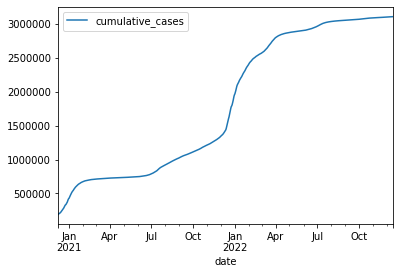

In [32]:
# plotting the visualisation with keeping date as x-axis as we need the cumulative cases over time.
t15_df.plot(x='date',y='cumulative_cases');

#### ANSWER
Looking at the graph, we can conclude that from January 2021 to June 2021, the cumulative cases attains a plateau as we can see that there is no rise in cases and it is maintained at the same level from January 2021 to June 2021. 

### TASK 16

In [33]:
# creating the intermediate df
# grouping by date and getting the sum of cumulative cases for that particular date 
t16_df = covid_data.groupby('date')['cumulative_cases'].sum()

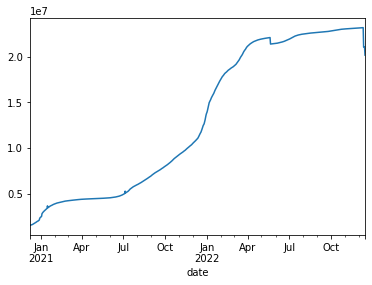

In [34]:
# plotting the visualisation with keeping date as x-axis as we need the cumulative cases over time.
t16_df.plot(x='date',y='cumulative_cases');

#### ANSWER
When we look at the plots for country-wise and London alone cumulative cases, the similarities between both the plots is that there's a plateau from January 2021 to June 2021 and from July 2021 the cases seems to rise as the line is increasing rapidly after December 2021. 

### TASK 17

In [35]:
# intermediate df
# creating a dataframe with only the required columns
t17_df = covid_data[['date','area','cumulative_cases']]

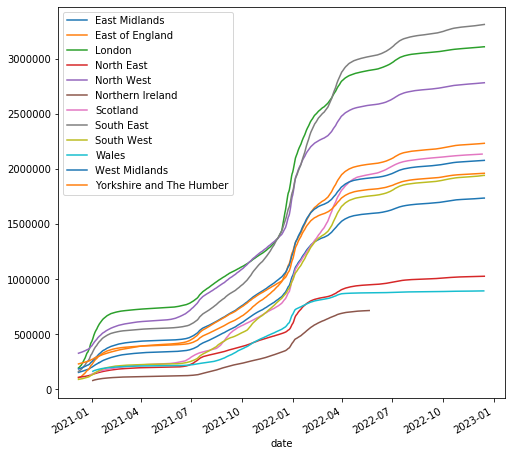

In [36]:
# Plotting the visualisation
# setting the index as date as we need the plot over the time 
t17_df.set_index('date',inplace=True)
# grouping by area as we need to compare every other area and then getting cumulaltive cases 
t17_df.groupby('area')['cumulative_cases'].plot(legend=True,figsize=(8,8));

#### ANSWER
The pattern among all nations/regions is that they all seems to have a plateau from January 2021 to June 2021, and the cases seems to increase right before January 2022 as we can see the line is exponentially increasing.

### TASK 18

#### ANSWER
Until June 2021, the cases seems to have attained a plateau, but after June 2021, the cases started to rise again gradually. The reason for this might be that the lockdown restrictions were lifted during that time and since the public were cramped inside the places for too long would have started to go out all together, which could have led to big gatherings in public places and this inturn would have started to spread the virus once again. 

### TASK 19

In [37]:
# Intermediate Df
# creating the dataframe for only the region 'London'
t19_df = covid_data[covid_data['area']=='London']
# using only the required columns for this task
t19_df = t19_df[['date','area','cumulative_deaths']]

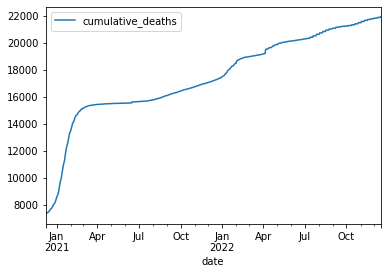

In [38]:
# plotting the visualisation
# keeping x axis a date since we need the cumulative deaths over the time.
t19_df.plot(x='date',y='cumulative_deaths');

#### ANSWER
The trend is broken during the month of feb 2021 - march 2021, as we can see that deaths were rising constantly but after march 2021, the deaths didn't rise and almost hit a plateau, as we can see from the graph that the line falls flat after the spike until march 2021, and then again increases gradually.

### TASK 20

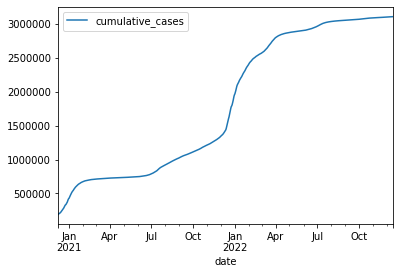

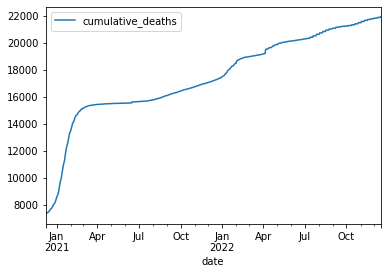

In [39]:
t15_df.plot(x='date',y='cumulative_cases'); # plotting the cumulative cases graph 
t19_df.plot(x='date',y='cumulative_deaths'); # plotting the cumulative deaths graph

#### ANSWER
Comparing both the graphs, we can see that there's a plateau from January 2021 to June 2021.
In Both plots the cases are increasing right after January 2022.
In Both plots the cases never seem to decrease after their spike from January 2022.

### TASK 21

In [40]:
# intermediate df
# creating a dataframe with only the required columns
t21_df = covid_data[['date','area','cumulative_cases','cumulative_deaths']]

In [41]:
# creating a new column and calculating the ratio of deaths to cases
t21_df['cumulative_deaths_per_cases'] = t21_df['cumulative_deaths']/t21_df['cumulative_cases']
t21_df

C:\anaconda\data\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,area,cumulative_cases,cumulative_deaths,cumulative_deaths_per_cases
8318,2020-12-08,East Midlands,151661.0,4868.0,0.032098
8317,2020-12-09,East Midlands,153071.0,4924.0,0.032168
8316,2020-12-10,East Midlands,154522.0,4963.0,0.032118
8315,2020-12-11,East Midlands,155966.0,5001.0,0.032065
8314,2020-12-12,East Midlands,157001.0,5066.0,0.032267
...,...,...,...,...,...
4957,2022-12-11,Yorkshire and The Humber,1958511.0,17833.0,0.009105
4956,2022-12-12,Yorkshire and The Humber,1958943.0,17833.0,0.009103
4955,2022-12-13,Yorkshire and The Humber,1959366.0,17833.0,0.009101
4954,2022-12-14,Yorkshire and The Humber,1959665.0,17833.0,0.009100


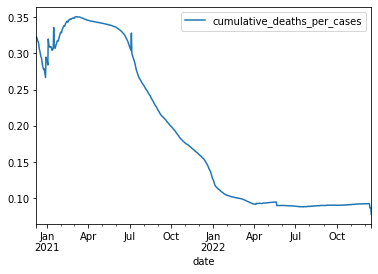

In [42]:
# plotting the visualisation
# grouping by date since we need it over time for all the regions and then plotting using the sum of cumulative_deaths_per_cases
t21_df.groupby('date')['cumulative_deaths_per_cases'].sum().plot(legend=True);

#### ANSWER
From the graph, we can point out that the ratio for deaths per cases has reached a peak during May 2021 - June 2021. They also reduce gradually after July 2021 and never seem to increase after that point. And eventually they reach a plateau from August 2022 - December 2022.

### TASK 22

#### ANSWER
The reason for inclination of the graph getting steeper might be because the Vaccinations were started to roll out from January 2021 by the government, so people started using vaccinations which might have helped people improve their immune system which resulted in the number of deaths decrease even if the people were affected by COVID-19. Also, there was a lockdown restriction implemented again during the time of May 2021 -  July 2021, which could have also helped to decrease the deaths and cases. 

### TASK 23

In [43]:
# intermediate df
# creating the dataframe by grouping by date and calculating the sum of cumulative cases for that particular date over all regions
t23_df = covid_data.groupby('date')['cumulative_vaccinated'].sum()

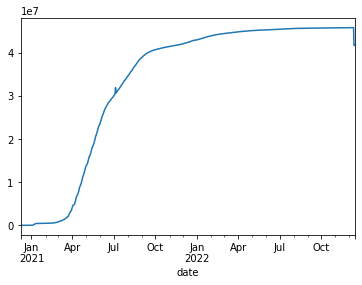

In [44]:
# plotting the visualisation
t23_df.plot();

#### ANSWER
Comparing this plot and the plot from task 21, we can clearly see that the number of people getting vaccinated increased from May-June 2021, and exactly after that time the number of deaths per cases have started to reduce significantly. So, the raltionship we can concur is that they are inversely proportional since the cumuative vaccinated increased the deaths per cases decreased. This also supports the statement I made in Task 22.

### TASK 24

In [45]:
# Intermediate df
# creating a dataframe with only required columns
t24_df = covid_data[['date','area','daily_cases_roll_avg']]

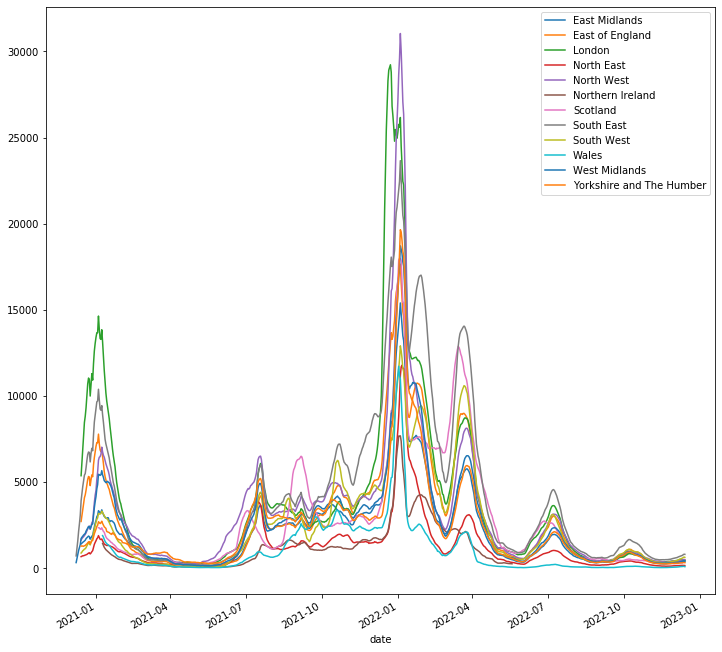

In [46]:
# plotting the visualisation
# setting the index as date as need the graph over time
t24_df.set_index('date',inplace=True)
# grouping by area as we need to compare the rolling averages among regions
t24_df.groupby('area')['daily_cases_roll_avg'].plot(figsize=(12,12),legend=True);

#### ANSWER
Looking at the graph, we can see that Northern Ireland has avoided the general trend. Every other region had a peak during January 2021 - March 2021, whereas Northern Ireland didn't peak  during that time and also has maintained a low number of  cases until January 2022. 

###  TASK 25

In [47]:
# intermediate df
# creating a dataframe with only the required columns for this task
t25_df = covid_data[['date','area','daily_cases_roll_avg']]
# setting the index as date we need the plot over time
t25_df.set_index('date',inplace=True)
# creating a dataframe for only North west
t25_a = t25_df[(t25_df['area']== 'North West')] 
# creating a dataframe for only Northern Ireland
t25_b = t25_df[(t25_df['area']== 'Northern Ireland')] 
# concatting them both to plot them in the same line plot
t25 = pd.concat([t25_a,t25_b]) 

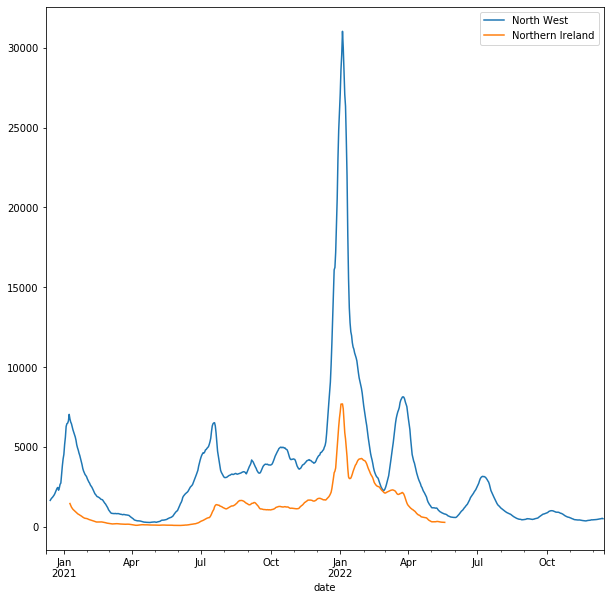

In [48]:
# plotting the visualisation
# grouping them by area as we need to compare both the regions with their daily cases rolling avg
t25.groupby('area')['daily_cases_roll_avg'].plot(legend=True,figsize=(10,10));

#### ANSWER
I took North West and Northern Ireland to compare, as I feel that North West follows the general trend whereas Northen ireland didn't follow the general trend. As you can see that from January 2021 to March 2021, North West had a peak where as in Northern Ireland the cases seem to be going down from January to March 2021. The only similarity between both the regions is that they both had a rise in cases during January 2022. But North West had a peak during April 2022, whereas Northern Ireland didn't have peak in cases during April 2022. These are the reasons, I feel that justify the statement that Northenr Ireland is avoding the general trend.

### TASK 26

In [49]:
# intermediate df
# creating a dataframe with only the required columns
t26_df = covid_data[['date','daily_cases_roll_avg','daily_deaths_roll_avg']]

# normalising the rolling average for daily deaths and daily cases
t26_df['daily_cases_roll_avg_norm'] = t26_df['daily_cases_roll_avg']/t26_df['daily_cases_roll_avg'].max() 
t26_df['daily_deaths_roll_avg_norm'] = t26_df['daily_deaths_roll_avg']/t26_df['daily_deaths_roll_avg'].max()

# creating the dataframe with the columns that are used to plot for this task
t26_df = t26_df[['date','daily_cases_roll_avg_norm','daily_deaths_roll_avg_norm']]

C:\anaconda\data\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\anaconda\data\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


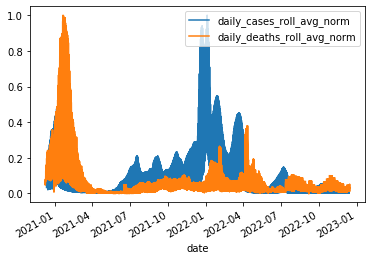

In [50]:
# plotting the visualisation
# we set the index as date and then plot it as we need to compare them over time
t26_df.set_index('date').plot();

#### ANSWER
We can say from the plot, that both daily cases and daily deaths are increasing and decreasing during the same time, though the numbers are very different. As in the vloume of daily deaths and daily cases are different, but whenever there's a peak or fall in daily cases there is a peak or fall in daily deaths as well. The proof for this can be seen during the time January 2021 - April 2021 where there is a peak in both the plots. From May 2021 - July 2021 both are seen to be decreasing and maintaing a plateau. And again in January 2022 we can see a increase in both cases.

### TASK 27

In [51]:
# CITATION - https://stackoverflow.com/questions/28337117/how-to-pivot-a-dataframe-in-pandas
# intermediate df
# creating a dataframe for only London
t27_df_london = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area']=='London'] 
# manipulating the dataframe with ony the required dataframes as it will be easy while plotting
t27_df_london = t27_df_london[['date','age','cumVaccinationFirstDoseUptakeByVaccinationDatePercentage']] 
# converting the dataframe to index as date with columns being age and the values of each row to be cumVaccinationFirstDoseUptakeByVaccinationDatePercentage
t27_df_london= t27_df_london.pivot(index='date', columns='age', values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')

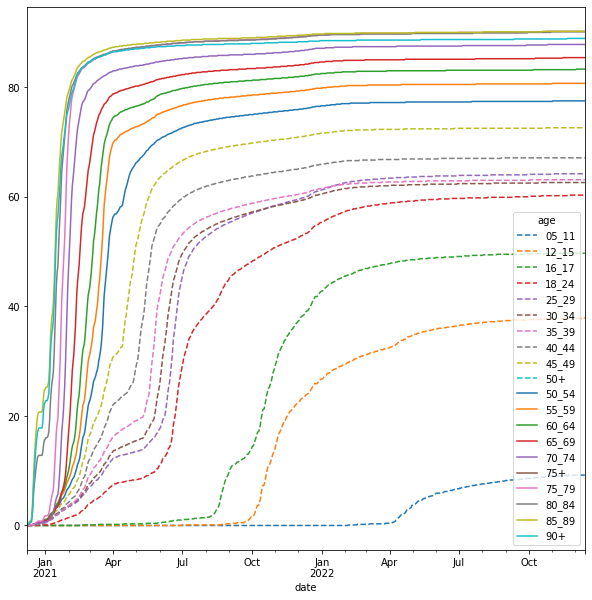

In [52]:
# plotting the visualisation
t27_df_london.plot(style=['--' for _ in range(10)],figsize=(10,10));

#### ANSWER
All age groups were not vaccinated equally and at the same time, there was a strategy employed. The strategy employed is that all the people above the age of 75+ were vaccinated initially, and then by each age group wise were vaccinated. People below the age of 18 were started to vaccinated only after May 2021. 

### TASK 28

In [53]:
# CITATION - https://stackoverflow.com/questions/28337117/how-to-pivot-a-dataframe-in-pandas
# intermediate df
# Creating a dataframe for only Scotland 
t28_df_scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area']=='Scotland'] 
# manipulating the dataframe with ony the required dataframes as it will be easy while plotting
t28_df_scotland = t28_df_scotland[['date','age','cumVaccinationFirstDoseUptakeByVaccinationDatePercentage']]
# converting the dataframe to index as date with columns being age and the values of each row to be cumVaccinationFirstDoseUptakeByVaccinationDatePercentage
t28_df_scotland= t28_df_scotland.pivot(index='date', columns='age', values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')

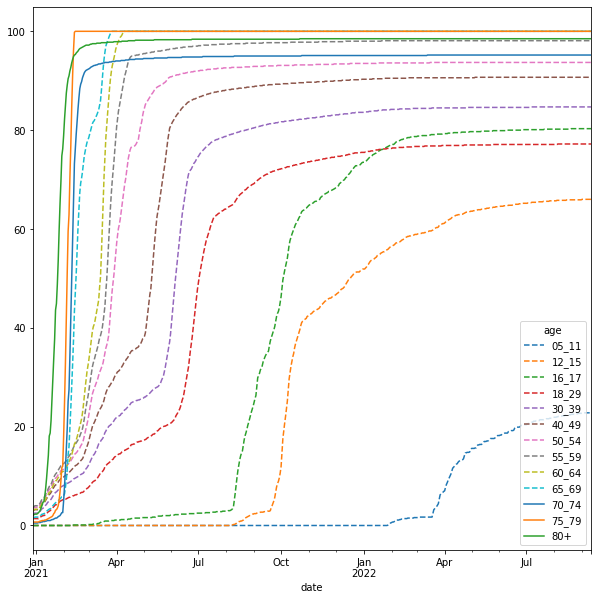

In [54]:
# plotting the visualisation
t28_df_scotland.plot(style=['--' for _ in range(10)],figsize=(10,10));

#### ANSWER
In both the plots, we can concur that age groups 50-64 and 65-79 were given the first preference to vaccination as the people belonged to this age group have been vaccinated from January 2021 itself. And the people vaccinated in age group from 50-64 and 65-79 have been increasing from January 2021 to April 2021 in both the plots. So, from this we can conclude that both the regions used the same strategy of vaccinating the elderly people as they are more prone to death due to covid. 